In [1]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import time
from pandas import ExcelWriter
from pandas import ExcelFile
from pprint import pprint
from scipy.stats import linregress

In [2]:
# File to Load (Remember to Change These)
fileordprod = "./data/brazilian-ecommerce/olist_order_items_dataset.csv"

# Read Purchasing File and store into Pandas data frame
ordprod = pd.read_csv(fileordprod)[['order_id', 'product_id', 'price']]
print(ordprod.shape)
ordprod.head()

(112650, 3)


,order_id,product_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90


In [3]:
# File to Load (Remember to Change These)
fileordcusttime = "./data/brazilian-ecommerce/olist_orders_dataset.csv"

# Read Purchasing File and store into Pandas data frame
ordcusttime= pd.read_csv(fileordcusttime)[['order_id', 'customer_id', 'order_purchase_timestamp']]
print(ordcusttime.shape)
ordcusttime.head()

(99441, 3)


,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


In [4]:
# File to Load (Remember to Change These)
fileprodcat = "./data/brazilian-ecommerce/olist_products_dataset.csv"

# Read Purchasing File and store into Pandas data frame
prodcat = pd.read_csv(fileprodcat)[['product_id', 'product_category_name']]
prodcat.head()


,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [5]:
# File to Load (Remember to Change These)
fileprodtransl = "./data/brazilian-ecommerce/product_category_name_translation.csv"

# Read Purchasing File and store into Pandas data frame
prodtransl = pd.read_csv(fileprodtransl)
prodtransl.head()


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [6]:
mergedf = pd.merge(ordcusttime, ordprod, on = 'order_id',how= 'left')
mergedf = pd.merge(mergedf, prodcat, on = 'product_id', how = 'left')
mergedf = pd.merge(mergedf, prodtransl, on = 'product_category_name', how = 'left')
renamecolumns = {
    'order_purchase_timestamp': 'order_time',
    'product_category_name_english': 'category'
}
mergedf = mergedf.rename(columns = renamecolumns)
print(mergedf.shape)

mergedf ["date_time"]= pd.to_datetime(mergedf['order_time'])

#mergedf = mergedf[['order_purchase_timestamp', 'product_category_name_english', 'price']]

#renamecolumns = {
  #  'order_purchase_timestamp': 'time',
    #'product_category_name_english': 'category'
#}
#mergedf = mergedf.rename(columns = renamecolumns)
#print(mergedf.shape)
#len(mergedf['category'].unique())



(113425, 7)


In [7]:
mergedf['YYYY'] = pd.DatetimeIndex(mergedf['date_time']).year
mergedf['MM'] = pd.DatetimeIndex(mergedf['date_time']).month
mergedf

#converted to MM/YY Format
mergedf['month'] = pd.to_datetime(mergedf['date_time'])
mergedf['day'] = mergedf['month'].dt.strftime('%m/%d/%y')
mergedf['month'] = mergedf['month'].dt.strftime('%m/%y')


mergedf.head()

,order_id,customer_id,order_time,product_id,price,product_category_name,category,date_time,YYYY,MM,month,day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,utilidades_domesticas,housewares,2017-10-02 10:56:33,2017,10,10/17,10/02/17
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumaria,perfumery,2018-07-24 20:41:37,2018,7,07/18,07/24/18
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,159.90,automotivo,auto,2018-08-08 08:38:49,2018,8,08/18,08/08/18
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,pet_shop,pet_shop,2017-11-18 19:28:06,2017,11,11/17,11/18/17
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,19.90,papelaria,stationery,2018-02-13 21:18:39,2018,2,02/18,02/13/18


In [8]:
# URL for GET requests to retrieve data
urlCPI = "https://www.quandl.com/api/v3/datasets/BCB/191.json?api_key=2vRuu5GNchksqBdcAHzc"
urlBOV = "https://www.quandl.com/api/v3/datasets/BCB/7.json?api_key=2vRuu5GNchksqBdcAHzc"
#urlEMP = "https://www.quandl.com/api/v3/datasets/BCB/10806.json?api_key=2vRuu5GNchksqBdcAHzc"

responseCPI = requests.get(urlCPI).json()
#print(json.dumps(response, indent=4, sort_keys=True))

responseBOV = requests.get(urlBOV).json()
#print(json.dumps(response, indent=4, sort_keys=True))

In [9]:
CPI_df = pd.DataFrame(responseCPI['dataset']['data'])

CPI_df = CPI_df.rename(index=str, columns={0: "month", 1: "CPI"})

CPI_df['month'] = pd.to_datetime(CPI_df['month'])
CPI_df['month'] = CPI_df['month'].dt.strftime('%m/%y')
#CPI_df.head()

In [10]:
days = 10

BOV_df = pd.DataFrame(responseBOV['dataset']['data'])

BOV_df = BOV_df.rename(index=str, columns={0: "day", 1: "BOV"})

BOV_df['day'] = pd.to_datetime(BOV_df['day'])
BOV_df['day'] = BOV_df['day'].dt.strftime('%m/%d/%y')
BOV_df['BOV'] = pd.to_numeric(BOV_df['BOV'])
BOV_df = BOV_df.sort_values(by = 'day', ascending = True)
BOV_df['BOVdiff'] = BOV_df['BOV'].diff(periods = days)
BOV_df['BOVma'] = BOV_df['BOV'].rolling(window = days).mean()
BOV_df.head()

,day,BOV,BOVdiff,BOVma
4458,01/02/01,15425.0,NaN,NaN
4208,01/02/02,13872.0,NaN,NaN
3955,01/02/03,11602.0,NaN,NaN
3702,01/02/04,22444.0,NaN,NaN
3199,01/02/06,33507.0,NaN,NaN


In [11]:
mergedf = pd.merge(mergedf, CPI_df, on = 'month', how = 'left')
mergedf = pd.merge(mergedf, BOV_df, on = 'day', how = 'left')

mergedf

,order_id,customer_id,order_time,product_id,price,product_category_name,category,date_time,YYYY,MM,month,day,CPI,BOV,BOVdiff,BOVma
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,utilidades_domesticas,housewares,2017-10-02 10:56:33,2017,10,10/17,10/02/17,0.33,74359.0,65539.0,51051.6
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,118.70,perfumaria,perfumery,2018-07-24 20:41:37,2018,7,07/18,07/24/18,0.17,79154.0,65393.0,55639.6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,159.90,automotivo,auto,2018-08-08 08:38:49,2018,8,08/18,08/08/18,0.07,79151.0,52440.0,56622.7
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,pet_shop,pet_shop,2017-11-18 19:28:06,2017,11,11/17,11/18/17,0.36,NaN,NaN,NaN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,19.90,papelaria,stationery,2018-02-13 21:18:39,2018,2,02/18,02/13/18,0.17,NaN,NaN,NaN
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,2017-07-09 21:57:05,060cb19345d90064d1015407193c233d,147.90,automotivo,auto,2017-07-09 21:57:05,2017,7,07/17,07/09/17,0.38,NaN,NaN,NaN
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,2017-04-11 12:22:08,a1804276d9941ac0733cfd409f5206eb,49.90,NaN,NaN,2017-04-11 12:22:08,2017,4,04/17,04/11/17,0.12,64359.0,52641.0,52457.2
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,2017-05-16 13:10:30,4520766ec412348b8d4caa5e8a18c464,59.99,automotivo,auto,2017-05-16 13:10:30,2017,5,05/17,05/16/17,0.52,68684.0,55460.0,53624.7
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,2017-01-23 18:29:09,ac1789e492dcd698c5c10b97a671243a,19.90,moveis_decoracao,furniture_decor,2017-01-23 18:29:09,2017,1,01/17,01/23/17,0.69,65748.0,54586.0,48357.2
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,2017-07-29 11:55:02,9a78fb9862b10749a117f7fc3c31f051,149.99,moveis_escritorio,office_furniture,2017-07-29 11:55:02,2017,7,07/17,07/29/17,0.38,NaN,NaN,NaN


In [12]:
mergedf['category'].unique()

array(['housewares', 'perfumery', 'auto', 'pet_shop', 'stationery', nan,
       'furniture_decor', 'office_furniture', 'garden_tools',
       'computers_accessories', 'bed_bath_table', 'toys',
       'construction_tools_construction', 'telephony', 'health_beauty',
       'electronics', 'baby', 'cool_stuff', 'watches_gifts',
       'air_conditioning', 'sports_leisure', 'books_general_interest',
       'small_appliances', 'food', 'luggage_accessories',
       'fashion_underwear_beach', 'christmas_supplies',
       'fashion_bags_accessories', 'musical_instruments',
       'construction_tools_lights', 'books_technical',
       'costruction_tools_garden', 'home_appliances', 'market_place',
       'agro_industry_and_commerce', 'party_supplies', 'home_confort',
       'cds_dvds_musicals', 'industry_commerce_and_business',
       'consoles_games', 'furniture_bedroom', 'construction_tools_safety',
       'fixed_telephony', 'drinks',
       'kitchen_dining_laundry_garden_furniture', 'fashion_sho

In [13]:
# red = fashion/clothing
    # 'perfumery', 'watches_gifts','fashion_underwear_beach','fashion_bags_accessories','fashion_shoes','fashion_male_clothing','fashion_sport','fashio_female_clothing','fashion_childrens_clothes'
# orange = home/furniture
    # 'housewares','furniture_decor','office_furniture','bed_bath_table','home_confort','furniture_bedroom','kitchen_dining_laundry_garden_furniture','home_comfort_2','furniture_mattress_and_upholstery'
# yellow = construction/tools
    # 'garden_tools','construction_tools_construction','construction_tools_lights','construction_tools_garden','construction_tools_safety','home_construction','construction_tools_tools'
# purple = electronics
    # 'computers_accessories','telephony','electionics','cds_dvds_musicals','consoles_games','audio','tablets_printing_image','computers','dvds_blu_ray','music'
# green = food and drink
    # 'food','drinks','food_drink','la_cuisine'
# cyan = books
    # 'books_general_interest','books_imported','books_technical'
# gray = appliances
    # 'air_conditioning','small_appliances','home_appliances','home_appliances_2','small_appliances_home_oven_and_coffee'

In [14]:

new_categories = {'fashion_clothing': ['perfumery', 'watches_gifts','fashion_underwear_beach','fashion_bags_accessories','fashion_shoes','fashion_male_clothing','fashion_sport','fashio_female_clothing','fashion_childrens_clothes'],
                  'home_furniture': ['housewares','furniture_decor','office_furniture','bed_bath_table','home_confort','furniture_bedroom','kitchen_dining_laundry_garden_furniture','home_comfort_2','furniture_mattress_and_upholstery'],
                  'construction_tools': ['garden_tools','construction_tools_construction','construction_tools_lights','construction_tools_garden','construction_tools_safety','home_construction','construction_tools_tools'],
                  'electronics': ['computers_accessories','telephony','electionics','cds_dvds_musicals','consoles_games','audio','tablets_printing_image','computers','dvds_blu_ray','music'],
                  'food_drink': ['food','drinks','food_drink','la_cuisine'],
                  'books': ['books_general_interest','books_imported','books_technical'],
                  'appliances': ['air_conditioning','small_appliances','home_appliances','home_appliances_2','small_appliances_home_oven_and_coffee']}

new_dict = {}
for key,valuelist in new_categories.items():
    for v in valuelist:
        new_dict[v] = key
print(new_dict)


{'perfumery': 'fashion_clothing', 'watches_gifts': 'fashion_clothing', 'fashion_underwear_beach': 'fashion_clothing', 'fashion_bags_accessories': 'fashion_clothing', 'fashion_shoes': 'fashion_clothing', 'fashion_male_clothing': 'fashion_clothing', 'fashion_sport': 'fashion_clothing', 'fashio_female_clothing': 'fashion_clothing', 'fashion_childrens_clothes': 'fashion_clothing', 'housewares': 'home_furniture', 'furniture_decor': 'home_furniture', 'office_furniture': 'home_furniture', 'bed_bath_table': 'home_furniture', 'home_confort': 'home_furniture', 'furniture_bedroom': 'home_furniture', 'kitchen_dining_laundry_garden_furniture': 'home_furniture', 'home_comfort_2': 'home_furniture', 'furniture_mattress_and_upholstery': 'home_furniture', 'garden_tools': 'construction_tools', 'construction_tools_construction': 'construction_tools', 'construction_tools_lights': 'construction_tools', 'construction_tools_garden': 'construction_tools', 'construction_tools_safety': 'construction_tools', 'hom

In [15]:
mergedf['category'] = mergedf.category.replace(new_dict)

In [16]:
#Rid of black friday
mergedf = mergedf.loc[mergedf['day'] != '11/24/17']

In [17]:
#commented out because it lags when rerunning all 

#save to excel file 

# writer = ExcelWriter('output.xlsx')
# mergedf.to_excel(writer,'Sheet1',index=False)
# writer.save()

In [18]:
home_furniture = mergedf['price'][mergedf['category']=='home_furniture'].sum()
fashion_clothing = mergedf['price'][mergedf['category']=='fashion_clothing'].sum()
construction_tools = mergedf['price'][mergedf['category']=='construction_tools'].sum()
electronics = mergedf['price'][mergedf['category']=='electronics'].sum()
food_drink = mergedf['price'][mergedf['category']=='food_drink'].sum()
books = mergedf['price'][mergedf['category']=='books'].sum()
appliances = mergedf['price'][mergedf['category']=='appliances'].sum()
#data['duration'][data['item'] == 'call'].sum()

total_spend = home_furniture + fashion_clothing + construction_tools + electronics + food_drink + books + appliances

category_spend = {home_furniture:'home_furniture',
                        fashion_clothing:'fashion_clothing',
                        construction_tools:'construction_tools',
                        electronics:'electronics',
                        food_drink:'food_drink',
                        books:'books',
                        appliances:'appliances'
                       }

In [19]:
mergedf['category'].nunique()

33

In [20]:
print(category_spend)

{2766837.39: 'home_furniture', 1778733.1400000001: 'fashion_clothing', 786502.8: 'construction_tools', 1828075.78: 'electronics', 68634.43000000001: 'food_drink', 70088.3: 'books', 483217.63: 'appliances'}


In [21]:
print(total_spend)

7782089.47


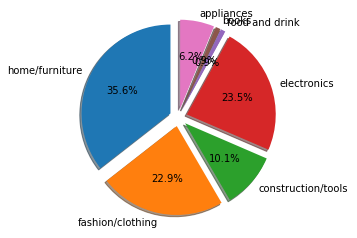

In [22]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'home/furniture', 'fashion/clothing', 'construction/tools', 'electronics','food and drink','books','appliances'
sizes = [home_furniture, fashion_clothing, construction_tools, electronics, food_drink, books, appliances]
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title = 'total spend'
plt.show()

In [23]:
#Black Friday!
mergedf.loc[mergedf['day'] == '11/24/17']

,order_id,customer_id,order_time,product_id,price,product_category_name,category,date_time,YYYY,MM,month,day,CPI,BOV,BOVdiff,BOVma


0.29643452467031634


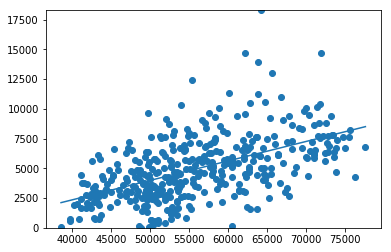

In [24]:
#scatter for BOVdiff and cateogries

groupdf = mergedf.groupby(['BOVdiff', 'category'])
groupdf = groupdf.sum()
#sum of prices
#groupdf = groupdf.sum()
groupdf.reset_index(inplace = True)
#why are there sum of prices at 0? no data from those dates?
groupdf = groupdf.loc[groupdf['price'] > 1]
#change categories
groupdf = groupdf.loc[groupdf['category'] == 'home_furniture']

plt.scatter(groupdf['BOVdiff'], groupdf['price'])
plt.ylim(0, max(groupdf['price']))
(slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf['BOVdiff'], groupdf['price'])

fitBOV = slopeBOV * groupdf['BOVdiff'] + interceptBOV
plt.plot(groupdf['BOVdiff'], fitBOV)
print(rBOV**2)

0.216475342197567


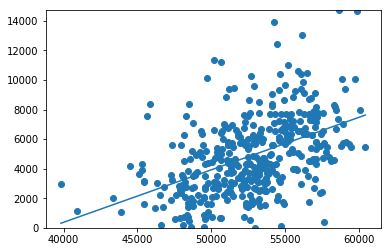

In [25]:
#scatter for BOVma and cateogries

groupdf = mergedf.groupby(['BOVma', 'category'])
groupdf = groupdf.sum()
#sum of prices
#groupdf = groupdf.sum()
groupdf.reset_index(inplace = True)
#why are there sum of prices at 0? no data from those dates?
groupdf = groupdf.loc[groupdf['price'] > 1]
#change categories
groupdf = groupdf.loc[groupdf['category'] == 'home_furniture']

plt.scatter(groupdf['BOVma'], groupdf['price'])
plt.ylim(0, max(groupdf['price']))
(slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf['BOVma'], groupdf['price'])

fitBOV = slopeBOV * groupdf['BOVma'] + interceptBOV
plt.plot(groupdf['BOVma'], fitBOV)
print(rBOV**2)

0.40885934206119445


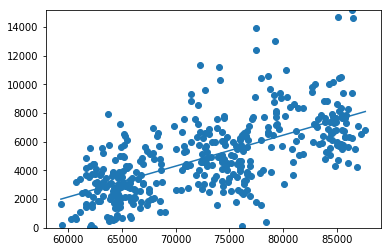

In [26]:
#scatter for BOV and cateogries

groupdf = mergedf.groupby(['BOV', 'category'])
#groupdf = groupdf.count()

groupdf = groupdf.sum()
groupdf.reset_index(inplace = True)
#why are there sum of prices at 0? no data from those dates?
groupdf = groupdf.loc[groupdf['price'] > 1]
#change categories
groupdf = groupdf.loc[groupdf['category'] == 'home_furniture']

plt.scatter(groupdf['BOV'], groupdf['price'])
plt.ylim(0, max(groupdf['price']))
(slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf['BOV'], groupdf['price'])

fitBOV = slopeBOV * groupdf['BOV'] + interceptBOV
plt.plot(groupdf['BOV'], fitBOV)
print(rBOV**2)

0.5545761696235183


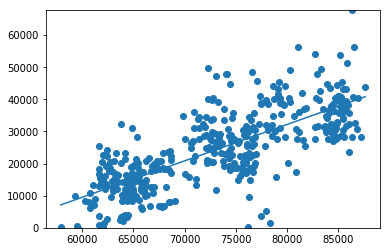

In [27]:
#scatter for BOV

groupdf = mergedf.groupby('BOV')
groupdf = groupdf.sum()
groupdf.reset_index(inplace = True)
#why are there sum of prices at 0? no data from those dates?
groupdf = groupdf.loc[groupdf['price'] > 1]


plt.scatter(groupdf['BOV'], groupdf['price'])
plt.ylim(0, max(groupdf['price']))
(slopeBOV, interceptBOV, rBOV, _, _) = linregress(groupdf['BOV'], groupdf['price'])

fitBOV = slopeBOV * groupdf['BOV'] + interceptBOV
plt.plot(groupdf['BOV'], fitBOV)
print(rBOV**2)

In [32]:
#used to see what the outlier point was
groupdf.sort_values('price', ascending= False).head()

,CPI,order_id,customer_id,order_time,product_id,price,product_category_name,category,date_time,YYYY,MM,month,day,BOV,BOVdiff,BOVma
5,0.17,23057,23057,23057,22981,22981,22679,22667,23057,23057,23057,23057,23057,16835,16835,16835
17,0.69,9223,9223,9223,9163,9163,8942,8942,9223,9223,9223,9223,9223,6860,6860,6860
9,0.34,8359,8359,8359,8338,8338,8260,8260,8359,8359,8359,8359,8359,6436,6436,6436
12,0.41,7945,7945,7945,7925,7925,7882,7880,7945,7945,7945,7945,7945,5981,5981,5981
10,0.36,7382,7382,7382,7299,7299,7190,7190,7382,7382,7382,7382,7382,4694,4694,4694


0.380935132983647


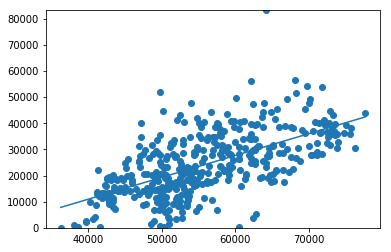

In [29]:
#scatter for BOVdiff

groupdf = mergedf.groupby('BOVdiff')
groupdf = groupdf.sum()
groupdf.reset_index(inplace = True)
#why are there sum of prices at 0? no data from those dates?
groupdf = groupdf.loc[groupdf['price'] > 1]


plt.scatter(groupdf['BOVdiff'], groupdf['price'])
plt.ylim(0, max(groupdf['price']))
(slopeBOVdiff, interceptBOVdiff, rBOVdiff, _, _) = linregress(groupdf['BOVdiff'], groupdf['price'])

fitBOVdiff = slopeBOVdiff * groupdf['BOVdiff'] + interceptBOVdiff
plt.plot(groupdf['BOVdiff'], fitBOVdiff)
print(rBOVdiff**2)

0.3007017489973056


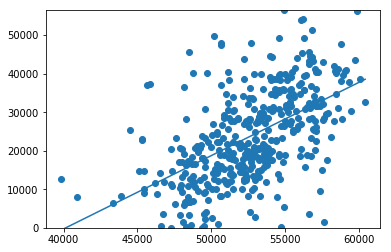

In [30]:
#scatter for BOVma

groupdf = mergedf.groupby('BOVma')
groupdf = groupdf.sum()
groupdf.reset_index(inplace = True)
#why are there sum of prices at 0? no data from those dates?
groupdf = groupdf.loc[groupdf['price'] > 1]


plt.scatter(groupdf['BOVma'], groupdf['price'])
plt.ylim(0, max(groupdf['price']))
(slopeBOVma, interceptBOVma, rBOVma, _, _) = linregress(groupdf['BOVma'], groupdf['price'])

fitBOVma = slopeBOVma * groupdf['BOVma'] + interceptBOVma
plt.plot(groupdf['BOVma'], fitBOVma)
print(rBOVma**2)

0.00359963996391434


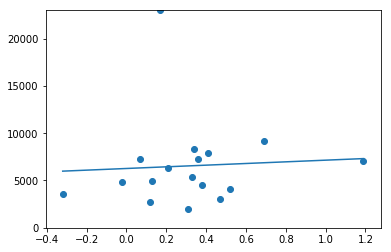

In [31]:
#scatter for CPI
#probably not usable

groupdf = mergedf.groupby('CPI')
groupdf = groupdf.count()
#sum of prices
#groupdf = groupdf.sum()
groupdf.reset_index(inplace = True)
#why are there sum of prices at 0? no data from those dates?
groupdf = groupdf.loc[groupdf['price'] > 1]


plt.scatter(groupdf['CPI'], groupdf['price'])
plt.ylim(0, max(groupdf['price']))
(slopeEMP, interceptEMP, rEMP, _, _) = linregress(groupdf['CPI'], groupdf['price'])

fitEMP = slopeEMP * groupdf['CPI'] + interceptEMP
plt.plot(groupdf['CPI'], fitEMP)
print(rEMP**2)